In [18]:
import os
import sys

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from six.moves.urllib.request import urlretrieve

wget not avaliable on windowns, use urlretrieve instead.

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

In [7]:
url = 'https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
local_weights_file = 'data/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
data_root = os.path.abspath('.')

def download(url, filename):
    dest_filename = os.path.join(data_root, filename)
    if not os.path.exists(dest_filename):
        print("Attempting to download:", filename)
        filename, _ = urlretrieve(url, dest_filename, reporthook=download_progress_hook)
        print('\nDownload Complete!')
#     statinfo = os.stat(dest_filename)
    return dest_filename

last_percent_reported = None
def download_progress_hook(count, blockSize, totalSize):
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)
    
    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write(f"{percent}%")
            sys.stdout.flush()
        else:
            sys.stdout.write('.')
            sys.stdout.flush()
            
    last_percent_reported = percent

In [8]:
download(url, local_weights_file)

Attempting to download: data/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!


'D:\\Github\\NLP\\TensorFlow_in_Practice_Specialization_Andrew_Ng_Coursera\\02_CNN_in_TensorFlow\\w3_Transfer_learning\\data/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [9]:
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

W1004 12:20:22.038441 12880 deprecation.py:506] From C:\Users\Administrator\Anaconda3\envs\nlp\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [12]:
pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
    layer.trainable = False

# pre_trained_model.summary()
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

In [13]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [15]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)           

model = Model(pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])

W1004 12:26:20.590363 12880 deprecation.py:323] From C:\Users\Administrator\Anaconda3\envs\nlp\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [19]:
# Define our example directories and files
base_dir = r"D:\Github\NLP\TensorFlow_in_Practice_Specialization_Andrew_Ng_Coursera\02_CNN_in_TensorFlow\w1_Exploring_a_larger_dataset\data\cats_and_dogs_filtered"

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')


train_cats_dir = os.path.join(train_dir, 'cats') # Directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') # Directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') # Directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')# Directory with our validation dog pictures

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [21]:
history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 1)

Epoch 1/20
100/100 [==============================] - 143s 1s/step - loss: 0.4022 - acc: 0.8140 - val_loss: 0.2708 - val_acc: 0.9310
Epoch 2/20
100/100 [==============================] - 140s 1s/step - loss: 0.3396 - acc: 0.8580 - val_loss: 0.2988 - val_acc: 0.9400
Epoch 3/20
100/100 [==============================] - 142s 1s/step - loss: 0.3162 - acc: 0.8615 - val_loss: 0.8180 - val_acc: 0.8810
Epoch 4/20
100/100 [==============================] - 150s 2s/step - loss: 0.3077 - acc: 0.8775 - val_loss: 0.3071 - val_acc: 0.9460
Epoch 5/20
100/100 [==============================] - 149s 1s/step - loss: 0.2899 - acc: 0.8770 - val_loss: 0.3571 - val_acc: 0.9450
Epoch 6/20
100/100 [==============================] - 153s 2s/step - loss: 0.2930 - acc: 0.8830 - val_loss: 0.4347 - val_acc: 0.9320
Epoch 7/20
100/100 [==============================] - 152s 2s/step - loss: 0.3053 - acc: 0.8815 - val_loss: 0.2785 - val_acc: 0.9590
Epoch 8/20
100/100 [==============================] - 156s 2s/step - 

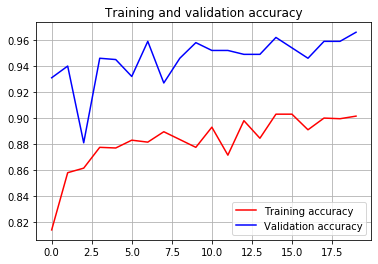

<Figure size 432x288 with 0 Axes>

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.grid()
plt.figure()


plt.show()

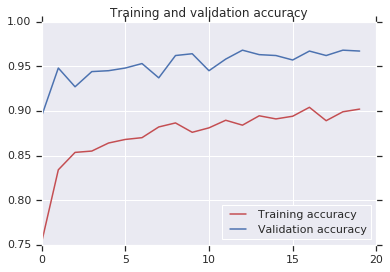

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()